In [ ]:
# CELL 1 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# CELL 2 — Load dataset
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print("Dataset Loaded:", filename)
df.head()


KeyboardInterrupt: 

In [ ]:
# CELL 3 — Show all columns
print("Columns in dataset:")
print(df.columns)
print("\nDataset shape:", df.shape)

# Drop ID/name/timestamp columns if present
drop_cols = ['user_id','name','timestamp','verification_date','last_transaction_date']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

df.head()


Columns in dataset:
Index(['age', 'gender', 'region', 'education_level', 'occupation',
       'annual_income', 'joint_income', 'business_income', 'property_value',
       'loan_amount', 'repayment_score', 'fraud_flag', 'id_verified',
       'document_validity', 'beneficiary_count', 'credit_score',
       'loan_status'],
      dtype='object')

Dataset shape: (20000, 17)


,age,gender,region,education_level,occupation,annual_income,joint_income,business_income,property_value,loan_amount,repayment_score,fraud_flag,id_verified,document_validity,beneficiary_count,credit_score,loan_status
0,24,Female,Mumbai,Diploma,Teacher,3455447,3095322.0,0,31160734,20000000,665,0,1,1.0,6,693,Rejected
1,55,Female,Hyderabad,High School,Farmer,664482,2034183.0,906967,8524582,2396276,714,0,1,NaN,3,715,Approved
2,49,Male,Ahmedabad,High School,Engineer,1817251,1666092.0,0,7643254,4595100,657,0,1,NaN,3,631,Approved
3,40,Male,Chennai,High School,Self Employed,1783071,NaN,196432,16058493,8811611,525,0,1,NaN,2,537,Rejected
4,40,Male,Delhi,PhD,Teacher,1734770,NaN,0,10155805,7323761,609,0,1,1.0,3,635,Rejected


In [ ]:
# CREDIT A1 — Prepare data (re-assign to be explicit)
selected_features = [
    'annual_income','joint_income','property_value','business_income',
    'loan_amount','repayment_score','beneficiary_count','age'
]
target = 'credit_score'

# use df_model from before; if not present, rebuild:
try:
    df_model
except NameError:
    df_model = df[selected_features + [target]].copy()

# ensure no NaNs
df_model = df_model.fillna(df_model.median())

X = df_model[selected_features].values
y = df_model[target].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shapes — X_train, X_test, y_train, y_test:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes — X_train, X_test, y_train, y_test: (16000, 8) (4000, 8) (16000,) (4000,)


In [ ]:
# CELL 5 — Missing value handling
df_model = df_model.fillna(df_model.median())   # fill numeric NA with median
print("Any NaN left?", df_model.isnull().sum().sum())


Any NaN left? 0


In [ ]:
# CREDIT A2 — Scaling for ANN (2D input)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler to disk if you want later (optional)
import joblib
joblib.dump(scaler, "credit_scaler.save")
print("Scaler saved as credit_scaler.save")
print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


Scaler saved as credit_scaler.save
Scaled shapes: (16000, 8) (4000, 8)


In [ ]:
# CELL 7 — Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((16000, 8), (4000, 8))

In [ ]:
# FIXED CREDIT ANN MODEL

ann_credit = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

ann_credit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

ann_credit.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# CREDIT A4 — Train ANN
from tensorflow.keras.callbacks import EarlyStopping
# FIXED TRAINING SETTINGS

es = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

history_ann = ann_credit.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=120,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 377152.6875 - mae: 605.3602 - val_loss: 228190.5938 - val_mae: 468.0349
Epoch 2/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 171322.6875 - mae: 389.6703 - val_loss: 34468.0312 - val_mae: 130.6892
Epoch 3/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36200.8594 - mae: 141.0639 - val_loss: 17075.5566 - val_mae: 76.3691
Epoch 4/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26258.3848 - mae: 120.7142 - val_loss: 10084.3105 - val_mae: 57.8588
Epoch 5/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19370.0566 - mae: 106.9087 - val_loss: 3654.3022 - val_mae: 39.7923
Epoch 6/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12629.1572 - mae: 90.3637 - val_loss: 1536.1936 - val_mae: 31.2179
Epoch 7/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9681.2539 - mae: 78.7429 - val_loss: 1296.5149 - val_mae: 29.2008
Epoch 8/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8039.4829 - mae: 71.5991 - val

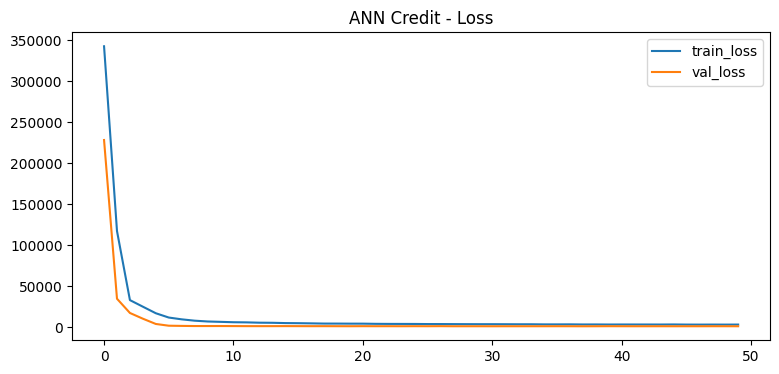

Ann Credit Test MSE: 853.4332275390625
Ann Credit Test MAE: 23.151182174682617


In [ ]:
# CREDIT A5 — Plot & evaluate
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(history_ann.history['loss'], label='train_loss')
plt.plot(history_ann.history['val_loss'], label='val_loss')
plt.legend(); plt.title("ANN Credit - Loss")
plt.show()

test_loss, test_mae = ann_credit.evaluate(X_test_scaled, y_test, verbose=0)
print("Ann Credit Test MSE:", test_loss)
print("Ann Credit Test MAE:", test_mae)


In [ ]:
# FIX — Impute numeric NaNs with median, then rebuild + rescale
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# List of fraud features (ensure same order)
fraud_features = [
    'annual_income','joint_income','business_income','property_value',
    'loan_amount','beneficiary_count','repayment_score','id_verified','document_validity'
]
fraud_target = 'fraud_flag'

# Impute numeric columns in df (median)
for col in fraud_features:
    if df[col].isnull().any():
        med = df[col].median()
        df[col] = df[col].fillna(med)

# Rebuild df_fraud
df_fraud = df[fraud_features + [fraud_target]].copy()

print("Any NaNs in df_fraud by column after median impute:")
print(df_fraud.isnull().sum())

# Recreate arrays and stratified split
Xf = df_fraud[fraud_features].values
yf = df_fraud[fraud_target].values
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    Xf, yf, test_size=0.2, random_state=42, stratify=yf
)

# Rescale safely (no NaNs now)
scaler_f = StandardScaler()
Xf_train_scaled = scaler_f.fit_transform(Xf_train)
Xf_test_scaled  = scaler_f.transform(Xf_test)
joblib.dump(scaler_f, "fraud_scaler.save")

print("Shapes after impute+split:", Xf_train.shape, Xf_test.shape)
print("Any NaNs in Xf_train_scaled:", np.isnan(Xf_train_scaled).sum())
print("Any Infs in Xf_train_scaled:", np.isinf(Xf_train_scaled).sum())
print("Fraud scaler saved. Ready to train.")


Any NaNs in df_fraud by column after median impute:
annual_income        0
joint_income         0
business_income      0
property_value       0
loan_amount          0
beneficiary_count    0
repayment_score      0
id_verified          0
document_validity    0
fraud_flag           0
dtype: int64
Shapes after impute+split: (16000, 9) (4000, 9)
Any NaNs in Xf_train_scaled: 0
Any Infs in Xf_train_scaled: 0
Fraud scaler saved. Ready to train.


In [ ]:
# CELL B3 — Build ANN fraud detection model

from tensorflow.keras import layers, models

ann_fraud = models.Sequential([
    layers.Input(shape=(Xf_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

ann_fraud.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ann_fraud.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# CELL B4 — Train fraud ANN with class weights
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

# compute class weights for imbalance
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(yf_train),
    y=yf_train
)
class_weights = {0: float(cw[0]), 1: float(cw[1])}
print("Class weights:", class_weights)

es_fraud = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history_fraud_ann = ann_fraud.fit(
    Xf_train_scaled, yf_train,
    validation_split=0.1,
    epochs=80,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[es_fraud],
    verbose=1
)


Class weights: {0: 0.5128862674701885, 1: 19.90049751243781}
Epoch 1/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6492 - loss: 0.6885 - val_accuracy: 0.6844 - val_loss: 0.5791
Epoch 2/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7259 - loss: 0.5215 - val_accuracy: 0.7944 - val_loss: 0.4181
Epoch 3/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7543 - loss: 0.5013 - val_accuracy: 0.8175 - val_loss: 0.3819
Epoch 4/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7885 - loss: 0.4574 - val_accuracy: 0.7581 - val_loss: 0.4745
Epoch 5/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7530 - loss: 0.4562 - val_accuracy: 0.7756 - val_loss: 0.4665
Epoch 6/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7675 - loss: 0.4489 - val_accuracy: 0.7663 - val_loss: 0.4642
Epoch 7/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7644 - loss: 0.4451 - val_accuracy: 0.7781 - val_loss: 0.4253
Epoch 8/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# CELL B5 — Evaluate fraud ANN (detailed metrics)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# Predict probabilities and binary labels
probs = ann_fraud.predict(Xf_test_scaled).ravel()
preds = (probs >= 0.5).astype(int)

# Basic metrics
print("Confusion Matrix:")
print(confusion_matrix(yf_test, preds))

print("\nClassification Report:")
print(classification_report(yf_test, preds, digits=4))

# ROC AUC (may be small because data is imbalanced but informative)
try:
    auc = roc_auc_score(yf_test, probs)
    print(f"\nROC AUC: {auc:.4f}")
except Exception as e:
    print("ROC AUC error:", e)

# Also show precision/recall for the positive class explicitly
p, r, f, _ = precision_recall_fscore_support(yf_test, preds, average=None, labels=[1,0])
print(f"\nPositive class (fraud) — Precision: {p[0]:.4f}, Recall: {r[0]:.4f}, F1: {f[0]:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Confusion Matrix:
[[3166  734]
 [  25   75]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9922    0.8118    0.8930      3900
           1     0.0927    0.7500    0.1650       100

    accuracy                         0.8103      4000
   macro avg     0.5424    0.7809    0.5290      4000
weighted avg     0.9697    0.8103    0.8748      4000


ROC AUC: 0.8810

Positive class (fraud) — Precision: 0.0927, Recall: 0.7500, F1: 0.1650


In [ ]:
# CELL B6 — Save Fraud ANN Model
ann_fraud.save("fraud_ann_model.h5")
print("Fraud ANN model saved as fraud_ann_model.h5")


Fraud ANN model saved as fraud_ann_model.h5


Any NaNs in df_fraud now by column:
annual_income            0
joint_income         11939
business_income          0
property_value           0
loan_amount              0
beneficiary_count        0
repayment_score          0
id_verified              0
document_validity        0
fraud_flag               0
dtype: int64
Shapes after fix: (16000, 9) (4000, 9)
Any NaNs in Xf_train_scaled: 9552
Any Infs in Xf_train_scaled: 0
Saved fraud_sc​​aler.save and rebuilt arrays. Ready to train.


In [ ]:
# CELL B7 — Example predictions for first 10 test samples

probs_10 = ann_fraud.predict(Xf_test_scaled[:10]).ravel()
preds_10 = (probs_10 >= 0.5).astype(int)

for i in range(10):
    print(f"Sample {i+1}:  Fraud Probability = {probs_10[i]:.4f}   Predicted Class = {preds_10[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Sample 1:  Fraud Probability = 0.3906   Predicted Class = 0
Sample 2:  Fraud Probability = 0.2963   Predicted Class = 0
Sample 3:  Fraud Probability = 0.1889   Predicted Class = 0
Sample 4:  Fraud Probability = 0.4789   Predicted Class = 0
Sample 5:  Fraud Probability = 0.6554   Predicted Class = 1
Sample 6:  Fraud Probability = 0.1285   Predicted Class = 0
Sample 7:  Fraud Probability = 0.2846   Predicted Class = 0
Sample 8:  Fraud Probability = 0.6210   Predicted Class = 1
Sample 9:  Fraud Probability = 0.4708   Predicted Class = 0
Sample 10:  Fraud Probability = 0.3198   Predicted Class = 0


In [ ]:
# FRAUD ANN — Accuracy Calculation

loss, accuracy = ann_fraud.evaluate(Xf_test_scaled, yf_test, verbose=0)

print(f"Fraud ANN Accuracy: {accuracy:.4f}")
print(f"Fraud ANN Loss: {loss:.4f}")


Fraud ANN Accuracy: 0.8102
Fraud ANN Loss: 0.3963


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top 5 thresholds by Recall:
 threshold  precision  recall       f1
      0.01   0.026199    1.00 0.051059
      0.02   0.027988    1.00 0.054451
      0.03   0.029447    0.99 0.057192
      0.04   0.030822    0.99 0.059783
      0.05   0.032070    0.99 0.062127

Top 5 thresholds by F1-score:
 threshold  precision  recall       f1
      0.83   0.325581    0.42 0.366812
      0.85   0.351852    0.38 0.365385
      0.84   0.339130    0.39 0.362791
      0.86   0.363636    0.36 0.361809
      0.80   0.284884    0.49 0.360294

Suggested threshold (heuristic): {'threshold': 0.23, 'precision': 0.05058572949946752, 'recall': 0.95, 'f1': 0.09605662285136501}


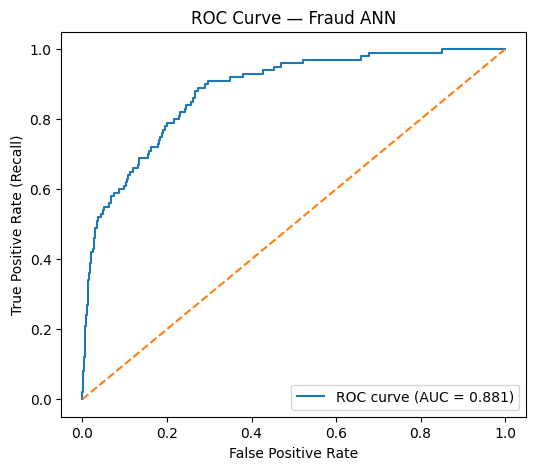


Threshold table (first 10 rows):
 threshold  precision  recall       f1
      0.01   0.026199    1.00 0.051059
      0.02   0.027988    1.00 0.054451
      0.03   0.029447    0.99 0.057192
      0.04   0.030822    0.99 0.059783
      0.05   0.032070    0.99 0.062127
      0.06   0.033311    0.99 0.064453
      0.07   0.034507    0.99 0.066689
      0.08   0.035357    0.99 0.068276
      0.09   0.036003    0.98 0.069454
      0.10   0.036494    0.97 0.070341


In [ ]:
# CELL B8 — Threshold tuning and ROC curve

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# predicted probabilities on test set
probs = ann_fraud.predict(Xf_test_scaled).ravel()

# thresholds to try
thresholds = np.linspace(0.01, 0.99, 99)
rows = []
for t in thresholds:
    preds_t = (probs >= t).astype(int)
    p = precision_score(yf_test, preds_t, zero_division=0)
    r = recall_score(yf_test, preds_t, zero_division=0)
    f = f1_score(yf_test, preds_t, zero_division=0)
    rows.append((t, p, r, f))

df_thresh = pd.DataFrame(rows, columns=['threshold','precision','recall','f1'])
# show top thresholds by recall (useful for fraud detection) and by f1
top_recall = df_thresh.sort_values(by='recall', ascending=False).head(5)
top_f1 = df_thresh.sort_values(by='f1', ascending=False).head(5)

print("Top 5 thresholds by Recall:")
print(top_recall.to_string(index=False))
print("\nTop 5 thresholds by F1-score:")
print(top_f1.to_string(index=False))

# suggest threshold: highest recall while precision >= 0.05 (example heuristic)
candidates = df_thresh[df_thresh['precision'] >= 0.05]
if not candidates.empty:
    suggested = candidates.sort_values(by='recall', ascending=False).iloc[0]
else:
    suggested = df_thresh.sort_values(by='recall', ascending=False).iloc[0]
print("\nSuggested threshold (heuristic):", suggested.to_dict())

# ROC curve
fpr, tpr, roc_thresh = roc_curve(yf_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve — Fraud ANN')
plt.legend()
plt.show()

# Display full table head for inspection
print("\nThreshold table (first 10 rows):")
print(df_thresh.head(10).to_string(index=False))


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import joblib
import tensorflow as tf

# Load models and scalers
credit_model = tf.keras.models.load_model("credit_ann_model.h5")
fraud_model  = tf.keras.models.load_model("fraud_ann_model.h5")

credit_scaler = joblib.load("credit_scaler.save")
fraud_scaler  = joblib.load("fraud_scaler.save")

THRESHOLD = 0.23   # chosen threshold

st.title("📊 Beneficiary Credit Scoring & Fraud Detection System")
st.write("Using ANN Models for Credit & Fraud Verification")

# Input Fields
annual_income = st.number_input("Annual Income", min_value=0)
joint_income  = st.number_input("Joint Income", min_value=0)
business_income = st.number_input("Business Income", min_value=0)
property_value = st.number_input("Property Value", min_value=0)
loan_amount = st.number_input("Loan Amount", min_value=0)
beneficiary_count = st.number_input("Family Members Count", min_value=1)
repayment_score = st.number_input("Repayment Score (0–1000)", min_value=0, max_value=1000)
id_verified = st.selectbox("ID Verified?", ["No", "Yes"])
document_validity = st.selectbox("Documents Valid?", ["Invalid", "Valid"])

# Convert categorical
id_verified = 1 if id_verified == "Yes" else 0
document_validity = 1 if document_validity == "Valid" else 0

# Button
if st.button("Calculate Credit Score & Fraud Risk"):

    # Prepare features
    credit_input = np.array([[annual_income, joint_income, business_income,
                              property_value, loan_amount, beneficiary_count,
                              repayment_score]])

    fraud_input = np.array([[annual_income, joint_income, business_income,
                             property_value, loan_amount, beneficiary_count,
                             repayment_score, id_verified, document_validity]])

    # Scale
    credit_scaled = credit_scaler.transform(credit_input)
    fraud_scaled  = fraud_scaler.transform(fraud_input)

    # Predictions
    credit_score = credit_model.predict(credit_scaled)[0][0]
    fraud_prob = fraud_model.predict(fraud_scaled)[0][0]
    fraud_label = 1 if fraud_prob >= THRESHOLD else 0

    # Output
    st.subheader("📈 Predicted Credit Score")
    st.write(f"**{credit_score:.2f}**")

    st.subheader("⚠️ Fraud Detection")
    st.write(f"Fraud Probability: **{fraud_prob:.3f}**")
    st.write(f"Fraud Detected (Threshold = {THRESHOLD}): **{'YES 🚨' if fraud_label==1 else 'NO ✔️'}**")


Overwriting app.py
